In [1]:
#!/usr/bin/python3.6
import random as r
import json

from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from AbstractArchitecture_v2 import AbstractArchitecture
from DenseEncoder import DenseEncoder
from DenseDecoder import DenseDecoder
from NormalizedMeanSquaredError import NormalizedMeanSquaredError as NMSE
from plot_model_prediction import plot_model_prediction


# Set Experiment Specifics
expt_name = "Experiment_03"
data_file_prefix = './data/NLSL_expt1'  ## FILL IN HERE (from file name)

# Network architecture design
l = 20  # Latent space size

activation = "relu"
initializer = tf.keras.initializers.VarianceScaling()
reg_lambda_l2 = 1e-6
regularizer = tf.keras.regularizers.l2(reg_lambda_l2)

act_layer = dict(activation=activation,
                 kernel_initializer=initializer,
                 kernel_regularizer=regularizer)
lin_layer = dict(activation=None,
                 kernel_initializer=initializer,
                 kernel_regularizer=regularizer)
latent_config = dict(activation=None, 
                     kernel_regularizer=regularizer,
                     use_bias=False)

encoder_layers = 5
decoder_layers = 5
add_identity = True

# Model training settings
## Set optimizer
optimizer = keras.optimizers.Adam
optimizer_opts = {}

# Callback function(s) and fit method options
cbs = [keras.callbacks.EarlyStopping(patience=10)]

# Batch size for model training
batch_size = 64

# Time to train autoencoders only and full models for initial seeding test
aec_only_time = 5  # minutes
full_model_time = 5  # minutes 

# This number is used to compute number of epochs for full-model training
final_model_train_hrs = 0.1


############################################
### Everything below here is automated!! ###
############################################

# Step 0. Assign a random number generator seed
x = r.randint(0, 10**(10))
r.seed(x)

# Step 1. Load in the data
data_train_u = np.load("{}_train1_u.npy".format(data_file_prefix))
data_train_f = np.load("{}_train1_f.npy".format(data_file_prefix))
data_val_u = np.load("{}_val_u.npy".format(data_file_prefix))
data_val_f = np.load("{}_val_f.npy".format(data_file_prefix))
data_test_u1 = np.load("{}_test1_u.npy".format(data_file_prefix))
data_test_f1 = np.load("{}_test1_f.npy".format(data_file_prefix))
data_test_u = np.load("{}_test2_u.npy".format(data_file_prefix))
data_test_f = np.load("{}_test2_f.npy".format(data_file_prefix))

# Step 2. Set up the model architecture
_, n = data_train_u.shape

encoder_config = {'units_full': n,
                  'num_layers': encoder_layers,
                  'actlay_config': act_layer,
                  'linlay_config': lin_layer,
                  'add_init_fin': add_identity}

decoder_config = {'units_full': n,
                  'num_layers': decoder_layers,
                  'actlay_config': act_layer,
                  'linlay_config': lin_layer,
                  'add_init_fin': add_identity}

# Aggregate settings for model architecture
architecture_config = {"units_latent": l,
                       "u_encoder_block": DenseEncoder(**encoder_config),
                       "u_decoder_block": DenseDecoder(**decoder_config),
                       "F_encoder_block": DenseEncoder(**encoder_config),
                       "F_decoder_block": DenseDecoder(**decoder_config),
                       "latent_config": latent_config}

In [2]:
# Create a model, initially only to train autoencoders!
model = AbstractArchitecture(**architecture_config,
                             train_autoencoders_only=True)

In [3]:
# Set the loss functions
loss_fns = 4*[NMSE()]

# Set up validation data for autoencoders-only
val_zeros = np.zeros(data_val_u.shape)
val_data = [(data_val_u, data_val_f), 
            (data_val_u, data_val_f, val_zeros, val_zeros)]

In [4]:
# Compute number of epochs to train
aec_epochs = int(aec_only_time*60*2)  # about 2 epochs/sec
full_epochs = int(full_model_time*60)  # about 1 epoch/sec

#aec_epochs = 1
#full_epochs = 3

# Randomly selected learning rate
lr = 10**(-r.uniform(3, 6))

In [5]:
# Compile the model
model.compile(loss=loss_fns,
              optimizer=optimizer(learning_rate=lr, **optimizer_opts))

# Fit the model
train_zeros = np.zeros(data_train_u.shape)
aec_hist = model.fit(x=[data_train_u, data_train_f],
                     y=[data_train_u, data_train_f, train_zeros, train_zeros],
                     validation_data=val_data,
                     callbacks=cbs,
                     batch_size=batch_size,
                     epochs=aec_epochs)


Train on 8906 samples, validate on 2227 samples
Epoch 1/600
8906/8906 [==============================] - 2s 266us/sample - loss: 1.9263 - output_1_loss: 0.9507 - output_2_loss: 0.9723 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 1.8429 - val_output_1_loss: 0.8997 - val_output_2_loss: 0.9404 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoch 2/600
8906/8906 [==============================] - 1s 80us/sample - loss: 1.7304 - output_1_loss: 0.8310 - output_2_loss: 0.8960 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 1.5875 - val_output_1_loss: 0.7480 - val_output_2_loss: 0.8366 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoch 3/600
8906/8906 [==============================] - 1s 75us/sample - loss: 1.4827 - output_1_loss: 0.6863 - output_2_loss: 0.7941 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 1.3745 - val_output_1_loss: 0.6215 - val_output_2_loss: 0.7500 - val_output_3_loss: 0.00

Epoch 25/600
8906/8906 [==============================] - 1s 73us/sample - loss: 0.6567 - output_1_loss: 0.3082 - output_2_loss: 0.3451 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.6251 - val_output_1_loss: 0.2872 - val_output_2_loss: 0.3352 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoch 26/600
8906/8906 [==============================] - 1s 74us/sample - loss: 0.6071 - output_1_loss: 0.2837 - output_2_loss: 0.3204 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.5750 - val_output_1_loss: 0.2615 - val_output_2_loss: 0.3108 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoch 27/600
8906/8906 [==============================] - 1s 73us/sample - loss: 0.5558 - output_1_loss: 0.2576 - output_2_loss: 0.2944 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.5272 - val_output_1_loss: 0.2369 - val_output_2_loss: 0.2874 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoch 2

Epoch 50/600
8906/8906 [==============================] - 1s 75us/sample - loss: 0.0853 - output_1_loss: 0.0213 - output_2_loss: 0.0614 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0893 - val_output_1_loss: 0.0215 - val_output_2_loss: 0.0652 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoch 51/600
8906/8906 [==============================] - 1s 80us/sample - loss: 0.0807 - output_1_loss: 0.0192 - output_2_loss: 0.0585 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0849 - val_output_1_loss: 0.0195 - val_output_2_loss: 0.0626 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoch 52/600
8906/8906 [==============================] - 1s 75us/sample - loss: 0.0765 - output_1_loss: 0.0174 - output_2_loss: 0.0561 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0809 - val_output_1_loss: 0.0179 - val_output_2_loss: 0.0603 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoch 5

Epoch 75/600
8906/8906 [==============================] - 1s 76us/sample - loss: 0.0370 - output_1_loss: 0.0052 - output_2_loss: 0.0293 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0412 - val_output_1_loss: 0.0058 - val_output_2_loss: 0.0327 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoch 76/600
8906/8906 [==============================] - 1s 76us/sample - loss: 0.0364 - output_1_loss: 0.0050 - output_2_loss: 0.0285 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0404 - val_output_1_loss: 0.0056 - val_output_2_loss: 0.0322 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoch 77/600
8906/8906 [==============================] - 1s 76us/sample - loss: 0.0358 - output_1_loss: 0.0049 - output_2_loss: 0.0288 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0399 - val_output_1_loss: 0.0055 - val_output_2_loss: 0.0317 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoch 7

Epoch 100/600
8906/8906 [==============================] - 1s 74us/sample - loss: 0.0271 - output_1_loss: 0.0026 - output_2_loss: 0.0219 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0306 - val_output_1_loss: 0.0031 - val_output_2_loss: 0.0249 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoch 101/600
8906/8906 [==============================] - 1s 73us/sample - loss: 0.0268 - output_1_loss: 0.0025 - output_2_loss: 0.0214 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0303 - val_output_1_loss: 0.0030 - val_output_2_loss: 0.0247 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoch 102/600
8906/8906 [==============================] - 1s 73us/sample - loss: 0.0265 - output_1_loss: 0.0024 - output_2_loss: 0.0212 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0300 - val_output_1_loss: 0.0029 - val_output_2_loss: 0.0245 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoc

Epoch 125/600
8906/8906 [==============================] - 1s 78us/sample - loss: 0.0224 - output_1_loss: 0.0017 - output_2_loss: 0.0178 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0255 - val_output_1_loss: 0.0022 - val_output_2_loss: 0.0207 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoch 126/600
8906/8906 [==============================] - 1s 76us/sample - loss: 0.0222 - output_1_loss: 0.0017 - output_2_loss: 0.0179 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0253 - val_output_1_loss: 0.0021 - val_output_2_loss: 0.0206 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoch 127/600
8906/8906 [==============================] - 1s 76us/sample - loss: 0.0221 - output_1_loss: 0.0017 - output_2_loss: 0.0176 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0251 - val_output_1_loss: 0.0021 - val_output_2_loss: 0.0204 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoc

Epoch 150/600
8906/8906 [==============================] - 1s 77us/sample - loss: 0.0196 - output_1_loss: 0.0013 - output_2_loss: 0.0157 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0224 - val_output_1_loss: 0.0018 - val_output_2_loss: 0.0180 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoch 151/600
8906/8906 [==============================] - 1s 77us/sample - loss: 0.0195 - output_1_loss: 0.0013 - output_2_loss: 0.0154 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0222 - val_output_1_loss: 0.0017 - val_output_2_loss: 0.0179 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoch 152/600
8906/8906 [==============================] - 1s 77us/sample - loss: 0.0194 - output_1_loss: 0.0013 - output_2_loss: 0.0153 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0221 - val_output_1_loss: 0.0017 - val_output_2_loss: 0.0178 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoc

Epoch 175/600
8906/8906 [==============================] - 1s 76us/sample - loss: 0.0177 - output_1_loss: 0.0011 - output_2_loss: 0.0138 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0201 - val_output_1_loss: 0.0014 - val_output_2_loss: 0.0160 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoch 176/600
8906/8906 [==============================] - 1s 75us/sample - loss: 0.0176 - output_1_loss: 0.0011 - output_2_loss: 0.0141 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0200 - val_output_1_loss: 0.0014 - val_output_2_loss: 0.0160 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoch 177/600
8906/8906 [==============================] - 1s 75us/sample - loss: 0.0175 - output_1_loss: 0.0011 - output_2_loss: 0.0138 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0199 - val_output_1_loss: 0.0014 - val_output_2_loss: 0.0159 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoc

8906/8906 [==============================] - 1s 76us/sample - loss: 0.0163 - output_1_loss: 9.2052e-04 - output_2_loss: 0.0126 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0184 - val_output_1_loss: 0.0013 - val_output_2_loss: 0.0146 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoch 200/600
8906/8906 [==============================] - 1s 75us/sample - loss: 0.0163 - output_1_loss: 9.1854e-04 - output_2_loss: 0.0126 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0183 - val_output_1_loss: 0.0012 - val_output_2_loss: 0.0145 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoch 201/600
8906/8906 [==============================] - 1s 77us/sample - loss: 0.0162 - output_1_loss: 9.1545e-04 - output_2_loss: 0.0125 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0183 - val_output_1_loss: 0.0012 - val_output_2_loss: 0.0144 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoch 

8906/8906 [==============================] - 1s 75us/sample - loss: 0.0152 - output_1_loss: 8.1147e-04 - output_2_loss: 0.0119 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0172 - val_output_1_loss: 0.0011 - val_output_2_loss: 0.0134 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoch 224/600
8906/8906 [==============================] - 1s 74us/sample - loss: 0.0152 - output_1_loss: 8.0567e-04 - output_2_loss: 0.0117 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0171 - val_output_1_loss: 0.0011 - val_output_2_loss: 0.0134 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoch 225/600
8906/8906 [==============================] - 1s 74us/sample - loss: 0.0152 - output_1_loss: 8.1491e-04 - output_2_loss: 0.0120 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0171 - val_output_1_loss: 0.0012 - val_output_2_loss: 0.0134 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoch 

8906/8906 [==============================] - 1s 74us/sample - loss: 0.0144 - output_1_loss: 7.1267e-04 - output_2_loss: 0.0109 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0162 - val_output_1_loss: 9.9935e-04 - val_output_2_loss: 0.0126 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoch 248/600
8906/8906 [==============================] - 1s 77us/sample - loss: 0.0143 - output_1_loss: 7.0774e-04 - output_2_loss: 0.0109 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0161 - val_output_1_loss: 9.8086e-04 - val_output_2_loss: 0.0125 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoch 249/600
8906/8906 [==============================] - 1s 74us/sample - loss: 0.0143 - output_1_loss: 6.9845e-04 - output_2_loss: 0.0108 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0161 - val_output_1_loss: 9.7703e-04 - val_output_2_loss: 0.0125 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.000

8906/8906 [==============================] - 1s 74us/sample - loss: 0.0136 - output_1_loss: 6.3751e-04 - output_2_loss: 0.0102 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0153 - val_output_1_loss: 8.7831e-04 - val_output_2_loss: 0.0118 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoch 272/600
8906/8906 [==============================] - 1s 74us/sample - loss: 0.0136 - output_1_loss: 6.3452e-04 - output_2_loss: 0.0102 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0153 - val_output_1_loss: 8.7858e-04 - val_output_2_loss: 0.0118 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoch 273/600
8906/8906 [==============================] - 1s 75us/sample - loss: 0.0135 - output_1_loss: 6.4508e-04 - output_2_loss: 0.0105 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0153 - val_output_1_loss: 8.7298e-04 - val_output_2_loss: 0.0118 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.000

8906/8906 [==============================] - 1s 74us/sample - loss: 0.0129 - output_1_loss: 5.7583e-04 - output_2_loss: 0.0096 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0146 - val_output_1_loss: 8.1906e-04 - val_output_2_loss: 0.0112 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoch 296/600
8906/8906 [==============================] - 1s 74us/sample - loss: 0.0129 - output_1_loss: 5.7113e-04 - output_2_loss: 0.0096 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0146 - val_output_1_loss: 8.1741e-04 - val_output_2_loss: 0.0112 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoch 297/600
8906/8906 [==============================] - 1s 74us/sample - loss: 0.0129 - output_1_loss: 5.7408e-04 - output_2_loss: 0.0097 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0146 - val_output_1_loss: 7.9790e-04 - val_output_2_loss: 0.0112 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.000

8906/8906 [==============================] - 1s 76us/sample - loss: 0.0123 - output_1_loss: 5.2534e-04 - output_2_loss: 0.0091 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0140 - val_output_1_loss: 7.4337e-04 - val_output_2_loss: 0.0107 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoch 320/600
8906/8906 [==============================] - 1s 75us/sample - loss: 0.0123 - output_1_loss: 5.2042e-04 - output_2_loss: 0.0091 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0140 - val_output_1_loss: 7.3695e-04 - val_output_2_loss: 0.0107 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoch 321/600
8906/8906 [==============================] - 1s 75us/sample - loss: 0.0123 - output_1_loss: 5.2341e-04 - output_2_loss: 0.0090 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0140 - val_output_1_loss: 7.3705e-04 - val_output_2_loss: 0.0107 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.000

8906/8906 [==============================] - 1s 77us/sample - loss: 0.0118 - output_1_loss: 4.8812e-04 - output_2_loss: 0.0086 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0135 - val_output_1_loss: 6.8607e-04 - val_output_2_loss: 0.0102 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoch 344/600
8906/8906 [==============================] - 1s 76us/sample - loss: 0.0118 - output_1_loss: 4.8950e-04 - output_2_loss: 0.0087 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0136 - val_output_1_loss: 7.0346e-04 - val_output_2_loss: 0.0103 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoch 345/600
8906/8906 [==============================] - 1s 75us/sample - loss: 0.0118 - output_1_loss: 4.8532e-04 - output_2_loss: 0.0086 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0135 - val_output_1_loss: 6.7948e-04 - val_output_2_loss: 0.0102 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.000

8906/8906 [==============================] - 1s 74us/sample - loss: 0.0113 - output_1_loss: 4.5130e-04 - output_2_loss: 0.0082 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0130 - val_output_1_loss: 6.3264e-04 - val_output_2_loss: 0.0098 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoch 368/600
8906/8906 [==============================] - 1s 74us/sample - loss: 0.0113 - output_1_loss: 4.5080e-04 - output_2_loss: 0.0082 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0130 - val_output_1_loss: 6.3817e-04 - val_output_2_loss: 0.0098 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoch 369/600
8906/8906 [==============================] - 1s 74us/sample - loss: 0.0113 - output_1_loss: 4.4788e-04 - output_2_loss: 0.0081 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0130 - val_output_1_loss: 6.4560e-04 - val_output_2_loss: 0.0098 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.000

8906/8906 [==============================] - 1s 75us/sample - loss: 0.0109 - output_1_loss: 4.3387e-04 - output_2_loss: 0.0082 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0127 - val_output_1_loss: 6.1105e-04 - val_output_2_loss: 0.0095 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoch 392/600
8906/8906 [==============================] - 1s 74us/sample - loss: 0.0109 - output_1_loss: 4.2042e-04 - output_2_loss: 0.0078 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0126 - val_output_1_loss: 5.9668e-04 - val_output_2_loss: 0.0094 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoch 393/600
8906/8906 [==============================] - 1s 75us/sample - loss: 0.0108 - output_1_loss: 4.1756e-04 - output_2_loss: 0.0077 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0125 - val_output_1_loss: 5.8216e-04 - val_output_2_loss: 0.0093 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.000

8906/8906 [==============================] - 1s 74us/sample - loss: 0.0105 - output_1_loss: 3.9739e-04 - output_2_loss: 0.0074 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0122 - val_output_1_loss: 5.6984e-04 - val_output_2_loss: 0.0091 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoch 416/600
8906/8906 [==============================] - 1s 75us/sample - loss: 0.0105 - output_1_loss: 4.0146e-04 - output_2_loss: 0.0076 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0122 - val_output_1_loss: 5.5294e-04 - val_output_2_loss: 0.0090 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoch 417/600
8906/8906 [==============================] - 1s 76us/sample - loss: 0.0105 - output_1_loss: 4.0281e-04 - output_2_loss: 0.0073 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0121 - val_output_1_loss: 5.6673e-04 - val_output_2_loss: 0.0090 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.000

8906/8906 [==============================] - 1s 74us/sample - loss: 0.0101 - output_1_loss: 3.7505e-04 - output_2_loss: 0.0073 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0119 - val_output_1_loss: 5.2809e-04 - val_output_2_loss: 0.0088 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoch 440/600
8906/8906 [==============================] - 1s 75us/sample - loss: 0.0101 - output_1_loss: 3.7428e-04 - output_2_loss: 0.0070 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0118 - val_output_1_loss: 5.2689e-04 - val_output_2_loss: 0.0087 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoch 441/600
8906/8906 [==============================] - 1s 74us/sample - loss: 0.0101 - output_1_loss: 3.7371e-04 - output_2_loss: 0.0070 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0118 - val_output_1_loss: 5.1950e-04 - val_output_2_loss: 0.0087 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.000

8906/8906 [==============================] - 1s 75us/sample - loss: 0.0097 - output_1_loss: 3.5776e-04 - output_2_loss: 0.0067 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0114 - val_output_1_loss: 4.9337e-04 - val_output_2_loss: 0.0084 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoch 464/600
8906/8906 [==============================] - 1s 75us/sample - loss: 0.0097 - output_1_loss: 3.5139e-04 - output_2_loss: 0.0067 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0115 - val_output_1_loss: 5.0790e-04 - val_output_2_loss: 0.0084 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoch 465/600
8906/8906 [==============================] - 1s 76us/sample - loss: 0.0097 - output_1_loss: 3.6266e-04 - output_2_loss: 0.0068 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0115 - val_output_1_loss: 5.1414e-04 - val_output_2_loss: 0.0084 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.000

8906/8906 [==============================] - 1s 76us/sample - loss: 0.0094 - output_1_loss: 3.4031e-04 - output_2_loss: 0.0066 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0111 - val_output_1_loss: 4.7624e-04 - val_output_2_loss: 0.0081 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoch 488/600
8906/8906 [==============================] - 1s 76us/sample - loss: 0.0093 - output_1_loss: 3.3171e-04 - output_2_loss: 0.0063 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0111 - val_output_1_loss: 4.6584e-04 - val_output_2_loss: 0.0081 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoch 489/600
8906/8906 [==============================] - 1s 77us/sample - loss: 0.0093 - output_1_loss: 3.3548e-04 - output_2_loss: 0.0063 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0111 - val_output_1_loss: 4.7380e-04 - val_output_2_loss: 0.0081 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.000

8906/8906 [==============================] - 1s 76us/sample - loss: 0.0090 - output_1_loss: 3.1890e-04 - output_2_loss: 0.0060 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0108 - val_output_1_loss: 4.4808e-04 - val_output_2_loss: 0.0078 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoch 512/600
8906/8906 [==============================] - 1s 75us/sample - loss: 0.0090 - output_1_loss: 3.2258e-04 - output_2_loss: 0.0060 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0108 - val_output_1_loss: 4.5612e-04 - val_output_2_loss: 0.0078 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoch 513/600
8906/8906 [==============================] - 1s 76us/sample - loss: 0.0090 - output_1_loss: 3.2191e-04 - output_2_loss: 0.0060 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0108 - val_output_1_loss: 4.4970e-04 - val_output_2_loss: 0.0078 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.000

8906/8906 [==============================] - 1s 76us/sample - loss: 0.0087 - output_1_loss: 3.0884e-04 - output_2_loss: 0.0057 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0105 - val_output_1_loss: 4.2012e-04 - val_output_2_loss: 0.0075 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoch 536/600
8906/8906 [==============================] - 1s 76us/sample - loss: 0.0087 - output_1_loss: 3.0455e-04 - output_2_loss: 0.0057 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0106 - val_output_1_loss: 4.5119e-04 - val_output_2_loss: 0.0075 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoch 537/600
8906/8906 [==============================] - 1s 75us/sample - loss: 0.0087 - output_1_loss: 3.0661e-04 - output_2_loss: 0.0057 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0105 - val_output_1_loss: 4.2097e-04 - val_output_2_loss: 0.0075 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.000

8906/8906 [==============================] - 1s 74us/sample - loss: 0.0084 - output_1_loss: 2.9429e-04 - output_2_loss: 0.0054 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0103 - val_output_1_loss: 4.0912e-04 - val_output_2_loss: 0.0073 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoch 560/600
8906/8906 [==============================] - 1s 74us/sample - loss: 0.0084 - output_1_loss: 2.9235e-04 - output_2_loss: 0.0054 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0102 - val_output_1_loss: 4.0226e-04 - val_output_2_loss: 0.0072 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoch 561/600
8906/8906 [==============================] - 1s 74us/sample - loss: 0.0084 - output_1_loss: 2.9201e-04 - output_2_loss: 0.0054 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0102 - val_output_1_loss: 4.1025e-04 - val_output_2_loss: 0.0072 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.000

8906/8906 [==============================] - 1s 74us/sample - loss: 0.0081 - output_1_loss: 2.8509e-04 - output_2_loss: 0.0052 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0100 - val_output_1_loss: 3.8646e-04 - val_output_2_loss: 0.0070 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoch 584/600
8906/8906 [==============================] - 1s 76us/sample - loss: 0.0081 - output_1_loss: 2.8031e-04 - output_2_loss: 0.0052 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0100 - val_output_1_loss: 3.9691e-04 - val_output_2_loss: 0.0070 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.0000e+00
Epoch 585/600
8906/8906 [==============================] - 1s 75us/sample - loss: 0.0081 - output_1_loss: 2.8276e-04 - output_2_loss: 0.0053 - output_3_loss: 0.0000e+00 - output_4_loss: 0.0000e+00 - val_loss: 0.0099 - val_output_1_loss: 3.8854e-04 - val_output_2_loss: 0.0070 - val_output_3_loss: 0.0000e+00 - val_output_4_loss: 0.000

In [6]:
# Set up validation data for full model
val_zeros = np.zeros(data_val_u.shape)
val_data = [(data_val_u, data_val_f), 
            (data_val_u, data_val_f, data_val_f, data_val_u)]

# Now set the model to train all aspects (including operator L)
model.train_autoencoders_only=False

# Compile the model
model.compile(loss=loss_fns,
              optimizer=optimizer(learning_rate=lr, **optimizer_opts))

hist = model.fit(x=[data_train_u, data_train_f],
                 y=[data_train_u, data_train_f, data_train_f, data_train_u],
                 validation_data=val_data,
                 #callbacks=cbs,
                 batch_size=batch_size,
                 epochs=full_epochs)

Train on 8906 samples, validate on 2227 samples
Epoch 1/300
8906/8906 [==============================] - 3s 318us/sample - loss: 325.5640 - output_1_loss: 0.0931 - output_2_loss: 0.0287 - output_3_loss: 1.0669 - output_4_loss: 320.8299 - val_loss: 133.1963 - val_output_1_loss: 0.1896 - val_output_2_loss: 0.0375 - val_output_3_loss: 1.0324 - val_output_4_loss: 130.1950
Epoch 2/300
8906/8906 [==============================] - 1s 91us/sample - loss: 83.6514 - output_1_loss: 0.2574 - output_2_loss: 0.0393 - output_3_loss: 1.0120 - output_4_loss: 80.2237 - val_loss: 57.7683 - val_output_1_loss: 0.3209 - val_output_2_loss: 0.0424 - val_output_3_loss: 0.9988 - val_output_4_loss: 54.5074
Epoch 3/300
8906/8906 [==============================] - 1s 91us/sample - loss: 42.2320 - output_1_loss: 0.3597 - output_2_loss: 0.0402 - output_3_loss: 0.9803 - output_4_loss: 38.7225 - val_loss: 33.8931 - val_output_1_loss: 0.4027 - val_output_2_loss: 0.0416 - val_output_3_loss: 0.9658 - val_output_4_loss: 3

Epoch 27/300
8906/8906 [==============================] - 1s 88us/sample - loss: 2.5611 - output_1_loss: 0.4379 - output_2_loss: 0.0413 - output_3_loss: 0.3927 - output_4_loss: 0.7331 - val_loss: 2.6200 - val_output_1_loss: 0.4417 - val_output_2_loss: 0.0461 - val_output_3_loss: 0.3880 - val_output_4_loss: 0.8054
Epoch 28/300
8906/8906 [==============================] - 1s 89us/sample - loss: 2.4568 - output_1_loss: 0.4284 - output_2_loss: 0.0411 - output_3_loss: 0.3801 - output_4_loss: 0.6883 - val_loss: 2.5192 - val_output_1_loss: 0.4348 - val_output_2_loss: 0.0465 - val_output_3_loss: 0.3772 - val_output_4_loss: 0.7592
Epoch 29/300
8906/8906 [==============================] - 1s 89us/sample - loss: 2.3602 - output_1_loss: 0.4188 - output_2_loss: 0.0410 - output_3_loss: 0.3695 - output_4_loss: 0.6495 - val_loss: 2.4132 - val_output_1_loss: 0.4209 - val_output_2_loss: 0.0463 - val_output_3_loss: 0.3661 - val_output_4_loss: 0.7139
Epoch 30/300
8906/8906 [==============================]

8906/8906 [==============================] - 1s 90us/sample - loss: 0.9193 - output_1_loss: 0.2001 - output_2_loss: 0.0389 - output_3_loss: 0.1937 - output_4_loss: 0.2258 - val_loss: 0.9550 - val_output_1_loss: 0.2041 - val_output_2_loss: 0.0440 - val_output_3_loss: 0.1962 - val_output_4_loss: 0.2537
Epoch 54/300
8906/8906 [==============================] - 1s 89us/sample - loss: 0.8865 - output_1_loss: 0.1935 - output_2_loss: 0.0388 - output_3_loss: 0.1897 - output_4_loss: 0.2183 - val_loss: 0.9246 - val_output_1_loss: 0.1969 - val_output_2_loss: 0.0437 - val_output_3_loss: 0.1917 - val_output_4_loss: 0.2467
Epoch 55/300
8906/8906 [==============================] - 1s 89us/sample - loss: 0.8565 - output_1_loss: 0.1857 - output_2_loss: 0.0382 - output_3_loss: 0.1852 - output_4_loss: 0.2093 - val_loss: 0.8913 - val_output_1_loss: 0.1896 - val_output_2_loss: 0.0431 - val_output_3_loss: 0.1875 - val_output_4_loss: 0.2360
Epoch 56/300
8906/8906 [==============================] - 1s 93us/sa

8906/8906 [==============================] - 1s 90us/sample - loss: 0.4223 - output_1_loss: 0.0744 - output_2_loss: 0.0287 - output_3_loss: 0.1070 - output_4_loss: 0.1006 - val_loss: 0.4519 - val_output_1_loss: 0.0799 - val_output_2_loss: 0.0334 - val_output_3_loss: 0.1119 - val_output_4_loss: 0.1162
Epoch 80/300
8906/8906 [==============================] - 1s 90us/sample - loss: 0.4110 - output_1_loss: 0.0721 - output_2_loss: 0.0284 - output_3_loss: 0.1046 - output_4_loss: 0.0976 - val_loss: 0.4382 - val_output_1_loss: 0.0762 - val_output_2_loss: 0.0328 - val_output_3_loss: 0.1084 - val_output_4_loss: 0.1125
Epoch 81/300
8906/8906 [==============================] - 1s 90us/sample - loss: 0.4019 - output_1_loss: 0.0698 - output_2_loss: 0.0281 - output_3_loss: 0.1020 - output_4_loss: 0.0953 - val_loss: 0.4302 - val_output_1_loss: 0.0759 - val_output_2_loss: 0.0326 - val_output_3_loss: 0.1058 - val_output_4_loss: 0.1097
Epoch 82/300
8906/8906 [==============================] - 1s 91us/sa

8906/8906 [==============================] - 1s 90us/sample - loss: 0.2551 - output_1_loss: 0.0369 - output_2_loss: 0.0224 - output_3_loss: 0.0635 - output_4_loss: 0.0573 - val_loss: 0.2846 - val_output_1_loss: 0.0416 - val_output_2_loss: 0.0274 - val_output_3_loss: 0.0679 - val_output_4_loss: 0.0711
Epoch 106/300
8906/8906 [==============================] - 1s 95us/sample - loss: 0.2514 - output_1_loss: 0.0355 - output_2_loss: 0.0222 - output_3_loss: 0.0624 - output_4_loss: 0.0563 - val_loss: 0.2716 - val_output_1_loss: 0.0382 - val_output_2_loss: 0.0263 - val_output_3_loss: 0.0668 - val_output_4_loss: 0.0643
Epoch 107/300
8906/8906 [==============================] - 1s 92us/sample - loss: 0.2485 - output_1_loss: 0.0349 - output_2_loss: 0.0221 - output_3_loss: 0.0617 - output_4_loss: 0.0557 - val_loss: 0.2730 - val_output_1_loss: 0.0392 - val_output_2_loss: 0.0261 - val_output_3_loss: 0.0684 - val_output_4_loss: 0.0639
Epoch 108/300
8906/8906 [==============================] - 1s 91us

Epoch 131/300
8906/8906 [==============================] - 1s 91us/sample - loss: 0.1914 - output_1_loss: 0.0202 - output_2_loss: 0.0183 - output_3_loss: 0.0490 - output_4_loss: 0.0427 - val_loss: 0.2234 - val_output_1_loss: 0.0268 - val_output_2_loss: 0.0235 - val_output_3_loss: 0.0541 - val_output_4_loss: 0.0562
Epoch 132/300
8906/8906 [==============================] - 1s 90us/sample - loss: 0.1919 - output_1_loss: 0.0204 - output_2_loss: 0.0183 - output_3_loss: 0.0487 - output_4_loss: 0.0435 - val_loss: 0.2079 - val_output_1_loss: 0.0216 - val_output_2_loss: 0.0226 - val_output_3_loss: 0.0527 - val_output_4_loss: 0.0484
Epoch 133/300
8906/8906 [==============================] - 1s 91us/sample - loss: 0.1869 - output_1_loss: 0.0192 - output_2_loss: 0.0179 - output_3_loss: 0.0482 - output_4_loss: 0.0409 - val_loss: 0.2073 - val_output_1_loss: 0.0216 - val_output_2_loss: 0.0221 - val_output_3_loss: 0.0530 - val_output_4_loss: 0.0484
Epoch 134/300
8906/8906 [===========================

Epoch 157/300
8906/8906 [==============================] - 1s 89us/sample - loss: 0.1606 - output_1_loss: 0.0133 - output_2_loss: 0.0157 - output_3_loss: 0.0424 - output_4_loss: 0.0358 - val_loss: 0.1814 - val_output_1_loss: 0.0160 - val_output_2_loss: 0.0197 - val_output_3_loss: 0.0472 - val_output_4_loss: 0.0434
Epoch 158/300
8906/8906 [==============================] - 1s 89us/sample - loss: 0.1602 - output_1_loss: 0.0134 - output_2_loss: 0.0157 - output_3_loss: 0.0425 - output_4_loss: 0.0358 - val_loss: 0.1776 - val_output_1_loss: 0.0149 - val_output_2_loss: 0.0197 - val_output_3_loss: 0.0468 - val_output_4_loss: 0.0412
Epoch 159/300
8906/8906 [==============================] - 1s 91us/sample - loss: 0.1592 - output_1_loss: 0.0132 - output_2_loss: 0.0157 - output_3_loss: 0.0421 - output_4_loss: 0.0352 - val_loss: 0.1762 - val_output_1_loss: 0.0148 - val_output_2_loss: 0.0197 - val_output_3_loss: 0.0463 - val_output_4_loss: 0.0406
Epoch 160/300
8906/8906 [===========================

Epoch 183/300
8906/8906 [==============================] - 1s 89us/sample - loss: 0.1422 - output_1_loss: 0.0097 - output_2_loss: 0.0141 - output_3_loss: 0.0383 - output_4_loss: 0.0316 - val_loss: 0.1573 - val_output_1_loss: 0.0108 - val_output_2_loss: 0.0180 - val_output_3_loss: 0.0424 - val_output_4_loss: 0.0359
Epoch 184/300
8906/8906 [==============================] - 1s 90us/sample - loss: 0.1417 - output_1_loss: 0.0098 - output_2_loss: 0.0147 - output_3_loss: 0.0392 - output_4_loss: 0.0317 - val_loss: 0.1577 - val_output_1_loss: 0.0106 - val_output_2_loss: 0.0180 - val_output_3_loss: 0.0428 - val_output_4_loss: 0.0362
Epoch 185/300
8906/8906 [==============================] - 1s 89us/sample - loss: 0.1433 - output_1_loss: 0.0102 - output_2_loss: 0.0143 - output_3_loss: 0.0386 - output_4_loss: 0.0325 - val_loss: 0.1653 - val_output_1_loss: 0.0130 - val_output_2_loss: 0.0185 - val_output_3_loss: 0.0426 - val_output_4_loss: 0.0413
Epoch 186/300
8906/8906 [===========================

Epoch 209/300
8906/8906 [==============================] - 1s 90us/sample - loss: 0.1314 - output_1_loss: 0.0082 - output_2_loss: 0.0132 - output_3_loss: 0.0357 - output_4_loss: 0.0300 - val_loss: 0.1498 - val_output_1_loss: 0.0124 - val_output_2_loss: 0.0168 - val_output_3_loss: 0.0410 - val_output_4_loss: 0.0334
Epoch 210/300
8906/8906 [==============================] - 1s 92us/sample - loss: 0.1299 - output_1_loss: 0.0080 - output_2_loss: 0.0130 - output_3_loss: 0.0355 - output_4_loss: 0.0292 - val_loss: 0.1440 - val_output_1_loss: 0.0087 - val_output_2_loss: 0.0167 - val_output_3_loss: 0.0396 - val_output_4_loss: 0.0328
Epoch 211/300
8906/8906 [==============================] - 1s 91us/sample - loss: 0.1292 - output_1_loss: 0.0077 - output_2_loss: 0.0130 - output_3_loss: 0.0353 - output_4_loss: 0.0292 - val_loss: 0.1528 - val_output_1_loss: 0.0095 - val_output_2_loss: 0.0176 - val_output_3_loss: 0.0395 - val_output_4_loss: 0.0404
Epoch 212/300
8906/8906 [===========================

Epoch 235/300
8906/8906 [==============================] - 1s 91us/sample - loss: 0.1211 - output_1_loss: 0.0067 - output_2_loss: 0.0123 - output_3_loss: 0.0332 - output_4_loss: 0.0278 - val_loss: 0.1354 - val_output_1_loss: 0.0073 - val_output_2_loss: 0.0161 - val_output_3_loss: 0.0381 - val_output_4_loss: 0.0308
Epoch 236/300
8906/8906 [==============================] - 1s 91us/sample - loss: 0.1208 - output_1_loss: 0.0067 - output_2_loss: 0.0122 - output_3_loss: 0.0332 - output_4_loss: 0.0277 - val_loss: 0.1363 - val_output_1_loss: 0.0078 - val_output_2_loss: 0.0160 - val_output_3_loss: 0.0368 - val_output_4_loss: 0.0328
Epoch 237/300
8906/8906 [==============================] - 1s 90us/sample - loss: 0.1221 - output_1_loss: 0.0071 - output_2_loss: 0.0126 - output_3_loss: 0.0336 - output_4_loss: 0.0285 - val_loss: 0.1395 - val_output_1_loss: 0.0096 - val_output_2_loss: 0.0159 - val_output_3_loss: 0.0380 - val_output_4_loss: 0.0330
Epoch 238/300
8906/8906 [===========================

Epoch 261/300
8906/8906 [==============================] - 1s 91us/sample - loss: 0.1187 - output_1_loss: 0.0072 - output_2_loss: 0.0122 - output_3_loss: 0.0322 - output_4_loss: 0.0287 - val_loss: 0.1277 - val_output_1_loss: 0.0068 - val_output_2_loss: 0.0153 - val_output_3_loss: 0.0350 - val_output_4_loss: 0.0302
Epoch 262/300
8906/8906 [==============================] - 1s 93us/sample - loss: 0.1134 - output_1_loss: 0.0058 - output_2_loss: 0.0116 - output_3_loss: 0.0313 - output_4_loss: 0.0262 - val_loss: 0.1263 - val_output_1_loss: 0.0064 - val_output_2_loss: 0.0151 - val_output_3_loss: 0.0350 - val_output_4_loss: 0.0295
Epoch 263/300
8906/8906 [==============================] - 1s 93us/sample - loss: 0.1142 - output_1_loss: 0.0060 - output_2_loss: 0.0120 - output_3_loss: 0.0316 - output_4_loss: 0.0270 - val_loss: 0.1260 - val_output_1_loss: 0.0064 - val_output_2_loss: 0.0152 - val_output_3_loss: 0.0348 - val_output_4_loss: 0.0294
Epoch 264/300
8906/8906 [===========================

Epoch 287/300
8906/8906 [==============================] - 1s 90us/sample - loss: 0.1082 - output_1_loss: 0.0055 - output_2_loss: 0.0111 - output_3_loss: 0.0299 - output_4_loss: 0.0256 - val_loss: 0.1377 - val_output_1_loss: 0.0091 - val_output_2_loss: 0.0163 - val_output_3_loss: 0.0335 - val_output_4_loss: 0.0407
Epoch 288/300
8906/8906 [==============================] - 1s 92us/sample - loss: 0.1106 - output_1_loss: 0.0061 - output_2_loss: 0.0116 - output_3_loss: 0.0305 - output_4_loss: 0.0276 - val_loss: 0.1225 - val_output_1_loss: 0.0064 - val_output_2_loss: 0.0147 - val_output_3_loss: 0.0339 - val_output_4_loss: 0.0296
Epoch 289/300
8906/8906 [==============================] - 1s 91us/sample - loss: 0.1108 - output_1_loss: 0.0062 - output_2_loss: 0.0114 - output_3_loss: 0.0302 - output_4_loss: 0.0273 - val_loss: 0.1226 - val_output_1_loss: 0.0067 - val_output_2_loss: 0.0146 - val_output_3_loss: 0.0337 - val_output_4_loss: 0.0298
Epoch 290/300
8906/8906 [===========================

In [7]:
### Step 3. Train 20 initial models, autoencoders-only then full model
## create a variety of different models with randomized learning rates
#num_init_models = 3
#models = []
#
## Set the loss functions
#loss_fns = 4*[NMSE()]
#
## Set up validation data for autoencoders-only
#val_zeros = np.zeros(data_val_u.shape)
#val_data = [(data_val_u, data_val_f), 
#            (data_val_u, data_val_f, val_zeros, val_zeros)]
#
## Compute number of epochs to train
#aec_epochs = int(aec_only_time*60*2)  # about 2 epochs/sec
#full_epochs = int(full_model_time*60)  # about 1 epoch/sec
#
#aec_epochs = 1
#full_epochs = 3
#
## For loop for generating the different models
#for i in range(num_init_models):
#    # Randomly selected learning rate
#    lr = 10**(-r.uniform(3, 6))
#    
#    # Create a model, initially only to train autoencoders!
#    model = AbstractArchitecture(**architecture_config,
#                                 train_autoencoders_only=True)
#    # Compile the model
#    model.compile(loss=loss_fns,
#                  optimizer=optimizer(learning_rate=lr, **optimizer_opts))
#
#    # Fit the model
#    train_zeros = np.zeros(data_train_u.shape)
#    aec_hist = model.fit(x=[data_train_u, data_train_f],
#                         y=[data_train_u, data_train_f, train_zeros, train_zeros],
#                         validation_data=val_data,
#                         callbacks=cbs,
#                         batch_size=batch_size,
#                         epochs=aec_epochs)
#    
#    # Now set the model to train all aspects (including operator L)
#    model.train_autoencoders_only=False
#    
#    hist = model.fit(x=[data_train_u, data_train_f],
#                     y=[data_train_u, data_train_f, data_train_f, data_train_u],
#                     validation_data=val_data,
#                     callbacks=cbs,
#                     batch_size=batch_size,
#                     epochs=full_epochs)
#    
#    # Append the results to the model list
#    models.append((model, hist, lr, aec_hist))
#
#
### Step 4. Select the best model from the 20 autoencoder-only results
#
## List of learning rates and final losses, losses averaged over final 5 epochs
#lrs = []
#final_losses = []
#
#for i in range(num_init_models):
#    _, hist, lr, _ = models[i]
#    final_losses.append(np.mean(hist.history['loss'][-5:]))
#    lrs.append(lr)
#
#
## Select the best model, based on the minimum in the final losses
#best_model_idc = np.argmin(final_losses)
#best_model = models[best_model_idc][0]
#best_lr = lrs[best_model_idc]
#
## Save weights for the best model
#model_weight_path = "./data/{}_best_aec_model_weights.tf".format(expt_name)
#best_model.save_weights(model_weight_path)
#
#
### Optional Step: Plot learning rates vs autoencoder-only losses
##plt.figure()
##plt.loglog(lrs, final_losses, 'o')
##plt.ylabel("Final Loss")
##plt.xlabel("Adam Learning Rate")
##plt.show()
#
#
#
### Step 5. Set up the full architecture run!!
#
## Set up validation data, loss functions, and number of epochs
#val_data = [(data_val_u, data_val_f), 
#            (data_val_u, data_val_f, data_val_f, data_val_u)]
#loss_fns = 4*[NMSE()]
#
## Compute number of epochs to fit full model
## about 1 epoch/sec in this step
#final_epochs = int(final_model_train_hrs*60*60) # 1 epoch/sec
#final_epochs = 3
#
## Instantiate the new model
#full_model = AbstractArchitecture(**architecture_config,
#                                  train_autoencoders_only=False)
#
## Load the weights
#full_model.load_weights(model_weight_path)
#full_model.compile(loss=loss_fns,
#                   optimizer=optimizer(learning_rate=best_lr))
#
## Continue training the (now full) model
#hist = full_model.fit(x=[data_train_u, data_train_f],
#                      y=[data_train_u, data_train_f, data_train_f, data_train_u],
#                      validation_data=val_data,
#                      callbacks=cbs,
#                      batch_size=batch_size,
#                      epochs=full_epochs)
#
## And save the final results!
#full_model_weights_path = "./data/{}_final_model_weights.tf".format(expt_name)
#full_model.save_weights(full_model_weights_path)
#
## Look at learning rates vs AEC-only and full-model losses
#lrs = []
#full_losses = []
#aec_losses = []
#for i in range(num_init_models):
#    _, full_hist, lr, aec_hist = models[i]
#    full_losses.append(np.mean(full_hist.history['loss'][-3:]))
#    aec_losses.append(np.mean(aec_hist.history['loss'][-3:]))
#    lrs.append(lr)
#    
### Optional Step: Plot learning rates vs autoencoder-only losses
##plt.figure()
##plt.loglog(lrs, full_losses, 'o', label="Full Models")
##plt.loglog(lrs, aec_losses, 'o', label="AEC Only")
##plt.ylabel("Final Loss")
##plt.xlabel("Adam Learning Rate")
##plt.legend()
##plt.show()
#
##min(aec_losses), min(full_losses)
#
##
#
### Doubled down on JSON for saving the data, since it is a uniform format!!
#
## Get the dictionary containing each metric and the loss for each epoch
#history_dict = hist.history.copy()
#
#for key in history_dict:
#    history_dict[key] = [val.astype(np.float64) for val in history_dict[key]]
#    
## And now dump it
#hist_filepath = "./data/{}_model_history.json".format(expt_name)
#json.dump(history_dict, open(hist_filepath, 'w'))
#
## Also dump the full_losses, aec_losses, and learning rates
#initial_training = {'aec_only_loss': aec_losses,
#                    'full_init_loss': full_losses,
#                    'learn_rates': lrs}
#init_train_filepath = "./data/{}_initial_train.json".format(expt_name)
#json.dump(initial_training, open(init_train_filepath, 'w'))

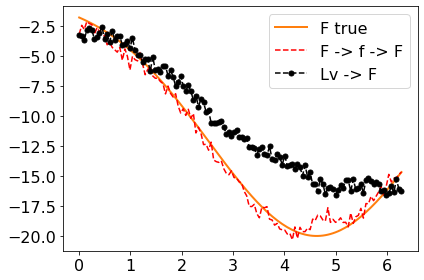

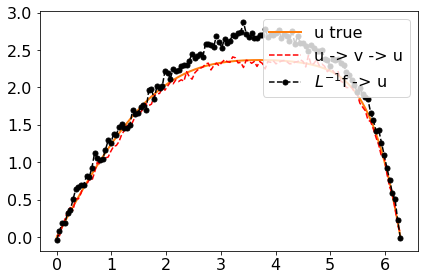

In [8]:
plot_model_prediction(model, 144, data_val_u, data_val_f)

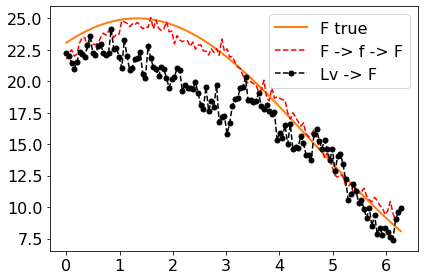

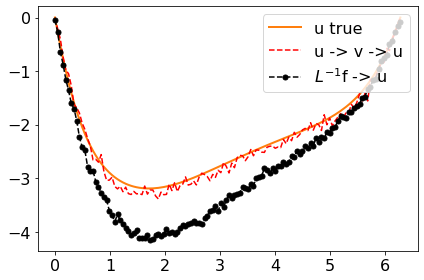

In [10]:
plot_model_prediction(model, 74, data_val_u, data_val_f)